<h1><center>Deep Learning</center></h1>
<h2><center>Assignment # 3</center></h2>
<h3><center>Task # 2</center></h3>

In [1]:
# Include libraries which may use in implementation
import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import scipy.misc as img
import glob
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import mxnet
import cv2
%matplotlib inline

<h1>A 2-Conv, 1-Pool, 2-FC Layer CNN</h1>

In [34]:
# Create a Neural_Network class
class Convolutional_Neural_Network(object): 
    def __init__(self,f = 5, conv1_filters = 10, conv2_filters = 10, fc1 = 128, fc2 = 10, channels_of_image=1, filter_size = 5):
        #conv1_filters = 8 
        #conv2_filters = 8
        self.filter1 = (conv1_filters,channels_of_image,filter_size,filter_size)
        self.filter1 = np.random.normal(loc = 0, scale = 1.0/np.sqrt(np.prod(self.filter1)), size = self.filter1)
        self.b1 = np.zeros((conv1_filters,1))
        
        self.filter2 = (conv2_filters ,conv1_filters,filter_size,filter_size)
        self.filter2 = np.random.normal(loc = 0, scale = 1.0/np.sqrt(np.prod(self.filter2)), size = self.filter2)
        self.b2 = np.zeros((conv2_filters,1))
        
        self.weightsfc1 = (fc1,1440)
        
        #self.weightsfc1 = (fc1,800)
        self.weightsfc1 = np.random.standard_normal(size=self.weightsfc1) * 0.01
        self.b3 = np.zeros((fc1,1))
        
        self.weightsfc2 = (fc2,fc1)
        self.weightsfc2 = np.random.standard_normal(size=self.weightsfc2) * 0.01
        self.b4 = np.zeros((fc2,1))
        
        self.mom_f1 = np.zeros(self.filter1.shape)
        self.mom_f2 = np.zeros(self.filter2.shape)
        self.mom_w1 = np.zeros(self.weightsfc1.shape)
        self.mom_w2 = np.zeros(self.weightsfc2.shape)
        self.mom_b1 = np.zeros(self.b1.shape)
        self.mom_b2 = np.zeros(self.b2.shape)
        self.mom_b3 = np.zeros(self.b3.shape)
        self.mom_b4 = np.zeros(self.b4.shape)
        
    
    def conv_forward(self,img, filters, bias, stride=1, pad=0):
        no_of_filters, filter_channels, filter_height, filter_width = filters.shape #filter_channels are actually channels of input
        image_channels, image_height, image_width = img.shape 
        output_volume = int((image_height - filter_height + 2*pad)/stride)+1 
        # final output after convolving all the filters with the image
        convolved_output = np.zeros((no_of_filters,output_volume,output_volume))
        for one_filter in range(no_of_filters):
            input_dim1 = 0
            for output_dim1 in range(output_volume):
                input_dim2 = 0
                for output_dim2 in range(output_volume):
                    f = filters[one_filter]
                    #print(f.shape)
                    #ll = img[:,input_dim1:input_dim1+filter_height, input_dim2:input_dim2+filter_height]
                    #print(ll.shape)
                    c = f*img[:,input_dim1:input_dim1+filter_height, input_dim2:input_dim2+filter_height]
                    convolved_output[one_filter,output_dim1,output_dim2]=np.sum(c) + bias[one_filter]
                    input_dim2+=stride
                input_dim1+=stride 
        #print(convolved_output.shape)
        #print(convolved_output)
        return convolved_output
    
    def pool_forward(self,feature_map, mode = 'max', filter_size=2, stride=2):
        no_of_channels, height, width = feature_map.shape
        width_new = int((width - filter_size)/stride)+1
        height_new = int((height - filter_size)/stride)+1
        pooled_output = np.zeros((no_of_channels, height_new, width_new))
        for channel in range(no_of_channels):
            input_dim1 = 0
            for output_dim1 in range(height_new):
                input_dim2 = 0
                for output_dim2 in range(width_new):
                    pooled_output[channel, output_dim1, output_dim2]= np.max(feature_map[channel,input_dim1:input_dim1+filter_size,input_dim2:input_dim2+filter_size])
                    if mode == 'average':
                        pooled_output[channel, output_dim1, output_dim2]= (1/4)*(np.sum(feature_map[channel,input_dim1:input_dim1+filter_size,input_dim2:input_dim2+filter_size]))
                    input_dim2+=stride
                input_dim1+=stride 
        return pooled_output 
    
    def conv_backward(self,prev_layer_input, layer_input,filters, stride=1,pad=0):
        no_of_filters, filter_channels, filter_height, filter_width = filters.shape #filter_channels are actually channels of input
        channels, height, width = layer_input.shape
        grad_output = np.zeros(layer_input.shape) 
        grad_filters = np.zeros(filters.shape)
        grad_biases = np.zeros((no_of_filters,1))
        #print(no_of_filters)
        for one_filter in range(no_of_filters):
            input_dim1 = 0
            for output_dim1 in range(height):
                input_dim2 = 0
                for output_dim2 in range(height):
                    if (((input_dim1+filter_height)<=height) and ((input_dim2+filter_height)<=height)):
                        #print('yes')
                        grad_filters[one_filter] += prev_layer_input[one_filter,input_dim1,input_dim2]*layer_input[:,input_dim1:input_dim1+filter_height, input_dim2:input_dim2+filter_height]
                        grad_output[:,input_dim1:input_dim1+filter_height,input_dim2:input_dim2+filter_height] += prev_layer_input[one_filter,input_dim1,input_dim2]*filters[one_filter]
                    input_dim2 += stride
                input_dim1 += stride
            grad_biases[one_filter] = np.sum(prev_layer_input[one_filter])
        return grad_output, grad_filters, grad_biases
    
    
    
    def pool_backward(self,prev_layer_input, layer_input,mode='max',filter_size=2, stride=2):
        #print(prev_layer_input.shape)
        channels, height, width = layer_input.shape
        grad_output = np.zeros(layer_input.shape)
        for channel in range(channels):
            input_dim1 = 0
            for output_dim1 in range(height):
                input_dim2 = 0
                for output_dim2 in range(height):
                    if ((input_dim1+filter_size)<=height) and ((input_dim2+filter_size)<=height):
                        #print('yes')
                        kk = layer_input[channel,input_dim1:input_dim1+filter_size, input_dim2:input_dim2+filter_size]
                        indices = np.nanargmax(kk)
                        k1,k2 = np.unravel_index(indices, kk.shape)#to get ij-th entry of the matrix
                        #print(channel,input_dim1+k1,input_dim2+k2)
                        grad_output[channel,input_dim1+k1,input_dim2+k2] = prev_layer_input[channel,output_dim1,output_dim2]
                        if mode == 'average':
                            grad_output[channel,input_dim1+k1,input_dim2+k2] = (1/4)*prev_layer_input[channel,output_dim1,output_dim2]  
                    input_dim2 += stride
                input_dim1 += stride
        return grad_output
    
    def softmax(self, output):
        exp_ = np.exp(output)
        return exp_/np.sum(exp_)
        
    def onehotencoder(self, y):
        one_hot_y = np.zeros((10,1)) 
        one_hot_y[int(y)] = 1.0 
        return one_hot_y
    
    def cross_entropy_loss(self,actual_Y, predicted_Y):
        actual_Y = self.onehotencoder(actual_Y)
        return -np.sum(actual_Y * np.log(predicted_Y))
    
    def relu(self, s):
        return np.maximum(0, s)
    
    def relu_derivative(self, s):
        s[s<=0] = 0
        s[s>0] = 1
        return s
    
    def sigmoid(self, s):
        # activation function
        return (1/(1+np.exp(-s))) #? # apply sigmoid function on s and return it's value

    def sigmoid_derivative(self, s):
        #derivative of sigmoid
        return self.sigmoid(s)*(1-self.sigmoid(s)) #? # apply derivative of sigmoid on s and return it's value 
    
    def tanh(self, s):
        # activation function
        return np.tanh(s) #? # apply tanh function on s and return it's value

    def tanh_derivative(self, s):
        #derivative of tanh
        return (1-(self.tanh(s))**2) #? # apply derivative of tanh on s and return it's value
    
    def leaky_relu(self, s):
        s[s < 0] *= .01
        return s

    def leaky_relu_derivative(self, s):
        s[s < 0] *= .01
        s[s > 0] = (int)(1)
        return s

    def forward_pass(self,image, predict = False):
        #Forward Pass
        c1 = self.conv_forward(image, self.filter1, self.b1)
        c1 = self.relu(c1)
        #c1 = self.sigmoid(c1)
        #c1 = self.tanh(c1)
        c2 = self.conv_forward(c1, self.filter2, self.b2)
        c2 = self.relu(c2)
        #c2 = self.sigmoid(c2)
        #c2 = self.tanh(c2)
        p = self.pool_forward(c2)
        channels, dim1, dim2 = p.shape
        flattened = p.reshape((channels * dim1 * dim1, 1)) 
        fc1 = np.dot(self.weightsfc1,flattened) + self.b3 
        fc1 = self.relu(fc1)
        #fc1 = self.sigmoid(fc1)
        #fc1 = self.tanh(fc1)
        fc2 = np.dot(self.weightsfc2,fc1) + self.b4 
        soft = self.softmax(fc2)
        if predict:
            return np.argmax(soft)
        
        return c1, c2, p, flattened, fc1, fc2, soft
    
    def backward_pass(self,image,c1, c2, p1, flat, fc1, fc2, softmax,label):
        
        label = self.onehotencoder(label)
        
        d_softmax = softmax - label
        dw2 = np.dot(d_softmax,fc1.T)
        db4 = np.sum(d_softmax, axis = 1)
        db4 = db4.reshape(self.b4.shape)
        d_fc1 = np.dot(self.weightsfc2.T,d_softmax)
        #d_fc1[fc1<=0] = 0 
        #d_fc1 = self.relu_derivative(d_fc1)
        d_fc1 = self.sigmoid_derivative(d_fc1)
        #d_fc1 = self.tanh_derivative(d_fc1)
        dw1 = np.dot(d_fc1,flat.T)
        db3 = np.sum(d_fc1, axis = 1)
        db3 = db3.reshape(self.b3.shape)
        d_flat = np.dot(self.weightsfc1.T,d_fc1)
        d_p1 = d_flat.reshape(p1.shape) #de-flattening
        d_c2 = self.pool_backward(d_p1, c2)
        #d_c2[c2<=0] = 0
        #d_c2 = self.relu_derivative(d_c2)
        d_c2 = self.sigmoid_derivative(d_c2)
        #d_c2 = self.tanh_derivative(d_c2)
        d_c1, df2, db2 = self.conv_backward(d_c2, c1, self.filter2)
        #d_c1[c1<=0] = 0 
        #d_c1 = self.relu_derivative(d_c1)
        d_c1 = self.sigmoid_derivative(d_c1)
        #d_c1 = self.tanh_derivative(d_c1)
        _ , df1, db1 = self.conv_backward(d_c1, image, self.filter1)
        
        k = [df1, df2, dw1, dw2, db1, db2, db3, db4]
        
        return k
    
        
        
    def sgd(self,gradients,lr):
        beta = 0.95
        [df1, df2, dw1, dw2, db1, db2, db3, db4] = gradients
        
        # Parameters Updation
        # SGD with momentum
        mom_f1 = np.zeros(self.filter1.shape)
        mom_f2 = np.zeros(self.filter2.shape)
        mom_w1 = np.zeros(self.weightsfc1.shape)
        mom_w2 = np.zeros(self.weightsfc2.shape)
        mom_b1 = np.zeros(self.b1.shape)
        mom_b2 = np.zeros(self.b2.shape)
        mom_b3 = np.zeros(self.b3.shape)
        mom_b4 = np.zeros(self.b4.shape)
    
        # conv filter 1
        mom_f1 = beta*mom_f1 + (1-beta)*df1
        self.filter1 -= lr * mom_f1
        # conv filter 2
        mom_f2 = beta*mom_f2 + (1-beta)*df2
        self.filter2 -= lr * mom_f2  
        # weighs fc1
        mom_w1 = beta*mom_w1 + (1-beta) * dw1
        self.weightsfc1 -= lr * mom_w1
        # weights fc2
        mom_w2 = beta*mom_w2 + (1-beta) * dw2
        self.weightsfc2 -= lr * mom_w2
        # bias 1
        mom_b1 = beta*mom_b1 + (1-beta)*db1
        self.b1 -= lr * mom_b1
        # bias 2   
        mom_b2 = beta*mom_b2 + (1-beta) * db2
        self.b2 -= lr * mom_b2
        # bias 3
        mom_b3 = beta*mom_b3 + (1-beta) * db3
        self.b3 -= lr * mom_b3
        # bias 4
        mom_b4 = beta*mom_b4 + (1-beta)*db4
        self.b4 -= lr * mom_b4
        
        
        
           
    def train( self, data, lr,training_epochs,  channels_of_image, image_dim, model_name):
        Loss = []
        Accuracy = []
        
        np.random.shuffle(data)
        datax = data[:,0:-1]
        datay = data[:,-1]
        epochs_list = []
        for epoch in range(training_epochs):
            #print(self.filter1[0][0])
            epochs_list.append(epoch)
            name = model_name + str(epoch) + '.mdl'
            loss_in_epoch = 0.0
            for i in range(len(datax)):       
                image = datax[i]
                #print(image.shape)
                image = image.reshape(channels_of_image,image_dim,image_dim)
                #print(image.shape)
                label = datay[i]
                #print(label)
                #return
                c1, c2, p, flattened, fc1, fc2, soft = self.forward_pass(image)
                gradients = self.backward_pass(image,c1, c2, p, flattened, fc1, fc2, soft, label)
                #print(self.filter1[0][0])
                self.sgd(gradients,lr)
                #print(self.filter1[0][0])
                loss = self.cross_entropy_loss(label,soft)
                loss_in_epoch += loss
            #print(self.filter1[0][0])
            self.saveModel(name)
            loss_in_epoch = loss_in_epoch/len(data)
            Loss.append(loss_in_epoch)
            accuracy = self.accuracy(data,channels_of_image,image_dim)
            Accuracy.append(accuracy)
            print("At epoch ",epoch, "loss is: ", loss_in_epoch, "accuracy is: ", accuracy)
            
            #plotting loss and accuracy of this experiment
        plt.plot(epochs_list,Loss,'bo')
        plt.xlabel('epoch number')
        plt.ylabel('Cross Entropy loss')
        plt.show()
        plt.plot(epochs_list,Accuracy)
        plt.xlabel('epoch number')
        plt.ylabel('Training Accuracy')
        plt.show()
        
        return Loss, Accuracy

    
    def accuracy(self,data,channels_of_image,image_dim, test = False):
        
            datax = data[:,0:-1]
            datay = data[:,-1]
            tp = 0

            actual_labels = []
            predicted_labels = []

            for i in range(len(datax)):
                actual_labels.append(int(datay[i]))
                image = datax[i]
                image = image.reshape(channels_of_image,image_dim,image_dim)
                pred = self.forward_pass(image, predict=True)
                predicted_labels.append(pred)
                if pred==datay[i]:
                    tp+=1
                
            accuracy = float(tp/len(data)*100)
            cnf_mat = confusion_matrix(actual_labels, predicted_labels)
            print(cnf_mat)
            if test:
                bar_label = ['Testing Accuracy']
                bar_index = np.arange(len(bar_label))
                plt.bar(bar_index,accuracy)
                #plt.xlabel('Testing')
                #plt.ylabel('Accuracy')
                plt.xticks(bar_index, bar_label, fontsize=10, rotation=0)
                plt.show()
            
            return accuracy

         
    def saveModel(self,name):
        pickle.dump(self, open(name, 'wb'))
        
    def loadModel(self,name):
        return pickle.load(open(name, 'rb'))

<h1>Loading Train and Test Data of MNIST</h1>

In [3]:
def load_dataset(path):
    print('Loading Dataset...')
    train_x =[]
    train_y =[]
    test_x  =[]
    test_y  =[]
    for i in range(10):
        for filename in glob.glob(path+'\\train\\'+str(i) +'\\*.png'):
            im = img.imread(filename)
            train_x.append(im)
            train_y.append(i)
    
    for i in range(10):
        for filename in glob.glob(path+'\\test\\'+str(i) +'\\*.png'):
            im = img.imread(filename)
            test_x.append(im)
            test_y.append(i)
            
    print('Dataset Loaded...')
    return np.array(train_x),np.array(train_y),np.array(test_x),np.array(test_y)

In [4]:
path_ = 'C:\\Users\\hp\\DL Assignments\\assignment3\\New folder\\Task1_Data'
train_set_x, train_set_y, test_set_x, test_set_y = load_dataset(path_)

Loading Dataset...


c:\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
c:\python36\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


Dataset Loaded...


In [60]:
test_set_x.shape[0]

10000

In [5]:
#Test Data
test_x = test_set_x.reshape((test_set_x.shape[0], 28 * 28))
t_dataX = test_x - np.mean(test_x)
t_dataX /= np.std(t_dataX)
t_dataY = test_set_y
t_dataY = t_dataY.reshape(10000,1)
test = np.hstack((t_dataX,t_dataY))
print(test.shape)
np.random.shuffle(test)
t_subset = test[:100]
t_subset.shape

(10000, 785)


(100, 785)

In [74]:
t_dataY[0]

array([0])

In [6]:
train_x = train_set_x.reshape((train_set_x.shape[0], 28 * 28))
dataX = train_x - np.mean(train_x)
dataX /= np.std(dataX)
dataY = train_set_y
dataY = dataY.reshape(60000,1)

In [7]:
td = np.hstack((dataX,dataY))
print(td.shape)
np.random.shuffle(td)

(60000, 785)


In [8]:
subset = td[:500]
subset.shape

(500, 785)

<h1>First Experiment with MNIST</h1>

In [22]:
model1 = Convolutional_Neural_Network()

In [23]:
model1.train(subset, lr=0.9,training_epochs=10, channels_of_image=1, image_dim=28)

[[25  0  0 10  0  1  4  0  2 16]
 [ 0 53  0  0  0  0  2  0  8  0]
 [ 0  2  9  7  0  0  3  0 19  2]
 [ 0  2  2 31  0  0  1  0  6  8]
 [ 0  1  0  0  6  0  5  0  3 32]
 [ 1  1  0  4  0  0 11  0  7 15]
 [ 4  0  3  0  0  0 39  0  0  2]
 [ 0  2  0  3  0  0  0  6 13 33]
 [ 1  1  0  0  0  0  6  0 37  1]
 [ 1  0  0  0  0  0  0  0  2 47]]
At epoch  0 loss is:  2.0228329292353107 accuracy is:  50.6
[[36  0  1  2  0  5  4  0  7  3]
 [ 0 56  3  0  0  0  1  0  3  0]
 [ 0  1 35  1  0  0  3  0  2  0]
 [ 0  2  1 40  0  4  0  1  2  0]
 [ 0  1  2  0 18  0  0  0  2 24]
 [ 0  0  0  3  0 19  1  0 10  6]
 [ 0  0  1  0  3  0 42  0  2  0]
 [ 0  1  1  1  0  0  0 40  0 14]
 [ 0  1  1  0  0  0  2  0 40  2]
 [ 1  0  0  0  1  0  0  0  1 47]]
At epoch  1 loss is:  1.5277694759232268 accuracy is:  74.6
[[55  0  1  0  1  0  0  0  1  0]
 [ 0 55  1  0  0  0  2  0  5  0]
 [ 0  0 39  0  1  0  1  0  1  0]
 [ 0  0  4 37  0  2  0  0  7  0]
 [ 0  1  0  0 46  0  0  0  0  0]
 [ 1  1  0  1  3 17  4  0  8  4]
 [ 0  0  0  0  0  0 

In [26]:
accuracy=model1.accuracy(t_subset,channels_of_image=1,image_dim=28, test = False)
print(accuracy)

[[ 4  0  0  1  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  1  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0]
 [ 0  0  3 10  0  0  0  1  0  0]
 [ 0  0  0  0 15  0  1  0  0  3]
 [ 0  0  1  1  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  3  0  0  0  4  0  0]
 [ 0  0  2  1  0  1  0  0  6  0]
 [ 0  1  0  1  2  0  0  0  0 10]]
77.0


<h1>Second Experiment with MNIST</h1>

In [39]:
model2 = Convolutional_Neural_Network()
#model2.saveModel('task2_model2_bestmodel.mdl')

In [40]:
model2.train(subset, lr=0.01,training_epochs=5, channels_of_image=1, image_dim=28)

[[48  0  5  3  0  0  2  0  0  0]
 [ 0 59  0  3  0  0  1  0  0  0]
 [ 2  0 29  5  0  0  5  1  0  0]
 [ 0  1  2 45  0  0  0  1  0  1]
 [ 0  0  0  0 33  0  5  0  0  9]
 [ 1  0  0 23  0  7  1  0  0  7]
 [ 0  0  0  0  0  0 48  0  0  0]
 [ 0  1  0  5  0  0  0 51  0  0]
 [ 1  1  0 40  0  1  1  0  0  2]
 [ 1  1  0  0  1  0  3  3  0 41]]
At epoch  0 loss is:  1.990034064274395 accuracy is:  72.2
[[46  0  7  0  0  4  1  0  0  0]
 [ 0 55  3  2  0  2  0  0  1  0]
 [ 0  0 39  2  0  0  0  1  0  0]
 [ 0  0  2 46  0  0  0  1  0  1]
 [ 0  0  1  0 33  1  1  0  0 11]
 [ 0  1  0  4  0 31  0  0  0  3]
 [ 0  0  2  0  1  1 44  0  0  0]
 [ 0  0  0  1  0  0  0 54  0  2]
 [ 0  2  3  9  0  9  0  1 21  1]
 [ 2  1  0  0  0  0  0  2  0 45]]
At epoch  1 loss is:  1.3137101655986427 accuracy is:  82.8
[[55  0  2  0  0  1  0  0  0  0]
 [ 0 59  0  0  0  0  0  0  4  0]
 [ 0  0 38  3  0  0  0  1  0  0]
 [ 0  1  0 46  0  0  0  2  1  0]
 [ 0  0  1  0 38  0  0  0  0  8]
 [ 0  0  0  5  0 32  0  0  0  2]
 [ 0  0  1  0  0  2 4

c:\python36\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in log
c:\python36\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in multiply


[[57  0  0  0  0  0  1  0  0  0]
 [ 0 59  0  0  0  0  1  0  3  0]
 [ 0  0 41  1  0  0  0  0  0  0]
 [ 1  0  1 43  0  2  0  2  1  0]
 [ 0  0  0  0 41  2  1  0  0  3]
 [ 0  0  0  0  0 39  0  0  0  0]
 [ 0  0  0  0  0  0 48  0  0  0]
 [ 0  0  1  0  0  0  0 55  0  1]
 [ 0  0  3  0  0  2  0  0 41  0]
 [ 2  0  0  0  1  1  1  1  0 44]]
At epoch  4 loss is:  nan accuracy is:  93.60000000000001


In [43]:
model2.saveModel('task2_model2_bestmodel.mdl')

In [41]:
accuracy2=model2.accuracy(t_subset,channels_of_image=1,image_dim=28, test = False)
print(accuracy2)

[[ 5  0  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0  0 10  1  0  0  0  0  0  0]
 [ 0  0  2  9  0  3  0  0  0  0]
 [ 0  0  0  0 17  1  1  0  0  0]
 [ 0  0  0  0  0  5  0  1  0  0]
 [ 0  0  0  0  0  0  6  0  0  0]
 [ 0  0  1  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 1  0  0  0  1  1  0  1  0 10]]
86.0


In [64]:
model3 = Convolutional_Neural_Network()
loaded_model = model3.loadModel('task2_model2_bestmodel.mdl')
accuracy3 = loaded_model.accuracy(t_subset,channels_of_image=1,image_dim=28, test = True)
print(accuracy3)

[[ 5  0  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0  0 10  1  0  0  0  0  0  0]
 [ 0  0  2  9  0  3  0  0  0  0]
 [ 0  0  0  0 17  1  1  0  0  0]
 [ 0  0  0  0  0  5  0  1  0  0]
 [ 0  0  0  0  0  0  6  0  0  0]
 [ 0  0  1  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 1  0  0  0  1  1  0  1  0 10]]
86.0


<h1>Third Experiment with MNIST</h1>

In [98]:
subset2 = td[:200]
subset2.shape

(200, 785)

In [109]:
model4 = Convolutional_Neural_Network()
#model4.saveModel('task2_model4_bestmodel.mdl')

In [110]:
model4.train(subset, lr=0.01,training_epochs=10, channels_of_image=1, image_dim=28, model_name = 'task2_model4_epoch')

[[53  0  1  0  0  0  4  0  0  0]
 [ 0 62  0  0  0  0  1  0  0  0]
 [ 1  0 20  2  0  0 16  3  0  0]
 [ 1  1  2 38  0  2  2  3  1  0]
 [ 0  1  0  0 34  0  9  0  0  3]
 [ 3  1  0  0  0 31  3  0  1  0]
 [ 0  1  0  0  0  0 47  0  0  0]
 [ 1  1  0  1  1  1  0 52  0  0]
 [ 4  5  0  1  0  2  4  1 29  0]
 [ 1  0  1  0 17  9  3  3  0 16]]
At epoch  0 loss is:  1.8510687891189677 accuracy is:  76.4
[[53  0  4  0  0  0  0  0  1  0]
 [ 0 60  1  0  0  1  1  0  0  0]
 [ 0  0 41  0  0  0  0  1  0  0]
 [ 0  0  4 38  0  3  0  3  2  0]
 [ 0  0  0  0 41  0  1  1  0  4]
 [ 1  0  2  0  0 34  0  0  1  1]
 [ 0  0  1  0  1  0 46  0  0  0]
 [ 1  0  3  0  0  0  0 53  0  0]
 [ 0  1  0  1  0  2  2  1 38  1]
 [ 1  0  0  0  3  0  0  2  0 44]]
At epoch  1 loss is:  1.1036038207871792 accuracy is:  89.60000000000001
[[56  0  0  0  1  0  0  1  0  0]
 [ 0 60  1  0  0  0  1  0  0  1]
 [ 0  0 41  0  0  0  0  0  1  0]
 [ 0  0  1 45  0  0  0  3  1  0]
 [ 0  0  0  0 42  0  0  1  0  4]
 [ 0  0  0  0  0 37  0  0  1  1]
 [ 0  0

c:\python36\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in log
c:\python36\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in multiply


[[48  0  0  0  1  8  0  0  1  0]
 [ 0 59  0  0  0  1  1  0  2  0]
 [ 0  0 41  0  0  0  0  0  1  0]
 [ 0  0  2 45  0  1  0  0  2  0]
 [ 0  0  0  0 39  0  0  1  0  7]
 [ 0  0  0  0  0 39  0  0  0  0]
 [ 0  0  1  0  0  0 46  0  0  1]
 [ 0  0  3  0  0  0  0 54  0  0]
 [ 0  0  0  0  0  2  1  0 43  0]
 [ 1  0  0  0  0  1  0  1  1 46]]
At epoch  3 loss is:  nan accuracy is:  92.0


c:\python36\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\python36\lib\site-packages\ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in less_equal
c:\python36\lib\site-packages\ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in less_equal
c:\python36\lib\site-packages\ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in less_equal
c:\python36\lib\site-packages\ipykernel_launcher.py:176: RuntimeWarning: invalid value encountered in less_equal


ValueError: All-NaN slice encountered

In [111]:
model4.saveModel('task2_model4_bestmodel.mdl')

[[2 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 1 0 0]
 [0 0 4 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 2 0]
 [0 0 0 1 0 0 0 0 2]]


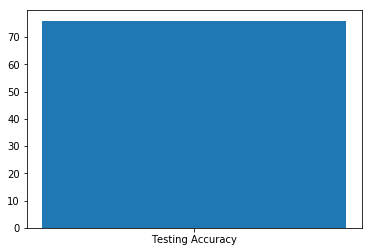

76.0


In [120]:
t_subset1 = test[:25]
t_subset1.shape
model_ = Convolutional_Neural_Network()
loaded_model_ = model_.loadModel('task2_model4_epoch5.mdl')
accuracy4 = loaded_model_.accuracy(t_subset1,channels_of_image=1,image_dim=28, test = True)
print(accuracy4)

<h1>Fourth Experiment with MNIST</h1>

In [121]:
model5 = Convolutional_Neural_Network()
#model5.saveModel('task2_model5_bestmodel.mdl')

In [122]:
model5.train(subset, lr=0.01,training_epochs=10, channels_of_image=1, image_dim=28, model_name = 'task2_model5_epoch')

[[56  0  0  0  0  2  0  0  0  0]
 [ 0 52  0  0  0  6  2  0  3  0]
 [ 0  0 22  0  0  2  3  1 14  0]
 [ 1  0  0 41  1  3  0  0  4  0]
 [ 0  0  1  0 41  4  1  0  0  0]
 [ 1  0  0  2  0 36  0  0  0  0]
 [ 0  0  1  0  0  0 47  0  0  0]
 [ 3  0  1  0  0  1  0 49  3  0]
 [ 1  0  0  1  0 10  2  0 32  0]
 [ 2  0  1  0 22 11  0  1  0 13]]
At epoch  0 loss is:  1.7930944252660637 accuracy is:  77.8
[[58  0  0  0  0  0  0  0  0  0]
 [ 0 60  1  0  0  0  0  0  2  0]
 [ 0  0 40  1  0  0  0  1  0  0]
 [ 0  0  1 46  0  1  0  1  1  0]
 [ 0  1  1  0 43  2  0  0  0  0]
 [ 1  0  1  1  0 35  0  0  1  0]
 [ 0  0  1  0  0  0 47  0  0  0]
 [ 1  0  1  2  0  1  0 52  0  0]
 [ 1  0  2  0  0  2  0  0 41  0]
 [ 2  0  0  0  4  5  0  2  0 37]]
At epoch  1 loss is:  1.0685072381910588 accuracy is:  91.8
[[58  0  0  0  0  0  0  0  0  0]
 [ 0 62  1  0  0  0  0  0  0  0]
 [ 0  0 40  1  0  0  0  0  1  0]
 [ 0  0  1 48  0  0  0  0  1  0]
 [ 0  0  1  0 45  1  0  0  0  0]
 [ 0  0  1  1  0 37  0  0  0  0]
 [ 0  0  7  0  0  0 

c:\python36\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\python36\lib\site-packages\ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in less_equal
c:\python36\lib\site-packages\ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in less_equal
c:\python36\lib\site-packages\ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in less_equal
c:\python36\lib\site-packages\ipykernel_launcher.py:176: RuntimeWarning: invalid value encountered in less_equal


ValueError: All-NaN slice encountered

[[2 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 6 1 0 0 0 0 0 0]
 [0 0 0 6 0 1 0 0 1 0]
 [0 0 0 0 7 1 0 0 0 0]
 [0 0 0 0 0 3 0 1 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 8 0]
 [1 0 0 0 2 0 0 0 0 3]]


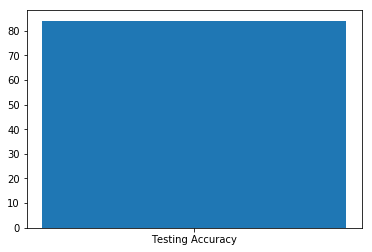

84.0


In [126]:
t_subset1 = test[:50]
t_subset1.shape
model_ = Convolutional_Neural_Network()
loaded_model_ = model_.loadModel('task2_model5_epoch1.mdl')
accuracy4 = loaded_model_.accuracy(t_subset1,channels_of_image=1,image_dim=28, test = True)
print(accuracy4)

<h1>Fifth Experiment with MNIST</h1>

In [18]:
model6 = Convolutional_Neural_Network()
#model6.saveModel('task2_model6_bestmodel.mdl')

In [19]:
model6.train(subset, lr=0.01,training_epochs=5, channels_of_image=1, image_dim=28, model_name = 'task2_model6_epoch')

[[43  0  0  0  0  0  8  0  1  0]
 [ 0 49  0  0  0  0  0  0  1  0]
 [ 0  2 25  7  0  0  5  0  7  0]
 [ 1  1  0 54  0  0  1  0  4  0]
 [ 0  0  0  0 30  0  1  0  5  0]
 [ 3  0  0  6  1 12  9  0 10  0]
 [ 0  0  0  0  0  0 60  0  0  0]
 [ 0  2  0  0  2  0  0 38  6  7]
 [ 0  0  0  3  1  0  0  1 50  0]
 [ 0  0  0  1 20  0  1  0 15  7]]
At epoch  0 loss is:  1.6852202350247414 accuracy is:  73.6
[[48  0  0  0  0  1  0  0  3  0]
 [ 0 49  0  0  0  0  0  0  1  0]
 [ 0  2 31  7  3  0  1  0  2  0]
 [ 0  2  0 57  0  0  0  0  2  0]
 [ 0  0  0  0 35  0  0  0  1  0]
 [ 0  0  0  2  1 28  0  0 10  0]
 [ 0  0  0  0  4  1 55  0  0  0]
 [ 0  1  0  1  2  0  0 43  3  5]
 [ 0  0  0  3  0  0  0  0 52  0]
 [ 0  0  0  0 18  2  0  0  5 19]]
At epoch  1 loss is:  1.045372215651552 accuracy is:  83.39999999999999
[[51  0  0  1  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  2 32 10  1  0  1  0  0  0]
 [ 0  0  1 59  0  0  0  0  1  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  1  0  6  0 24  3  0  7  0]
 [ 1  0 

c:\python36\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


[[51  0  0  0  0  0  0  0  1  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  2 34  9  0  0  0  0  1  0]
 [ 1  0  0 58  0  0  0  0  2  0]
 [ 0  0  0  0 35  0  0  0  1  0]
 [ 0  1  0  2  0 32  0  0  6  0]
 [ 1  0  0  0  0  1 58  0  0  0]
 [ 0  0  0  0  0  0  0 52  2  1]
 [ 0  0  0  4  0  0  0  0 51  0]
 [ 0  0  0  1  3  1  0  0  4 35]]
At epoch  3 loss is:  0.5676882606544341 accuracy is:  91.2


c:\python36\lib\site-packages\ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in less_equal
c:\python36\lib\site-packages\ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in less_equal
c:\python36\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\python36\lib\site-packages\ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in less_equal
c:\python36\lib\site-packages\ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in less_equal


ValueError: All-NaN slice encountered

In [43]:
t_subset1 = test[:50]
t_subset1.shape

(50, 785)

[[6 0 0 0 1 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 1 0]
 [0 0 2 0 0 0 0 0 1 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 8 1 1]
 [0 0 0 0 0 1 0 0 3 0]
 [0 0 0 0 5 1 0 0 1 0]]


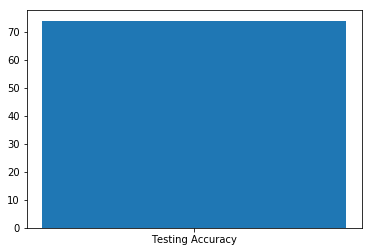

74.0


In [47]:
model_ = Convolutional_Neural_Network()
loaded_model_ = model_.loadModel('task2_model6_epoch1.mdl')
accuracy4 = loaded_model_.accuracy(t_subset1,channels_of_image=1,image_dim=28, test = True)
print(accuracy4)

In [9]:
subsetx = td[:50]
subsetx.shape

(50, 785)

In [10]:
modelx = Convolutional_Neural_Network()
#modelx.saveModel('task2_modelx_bestmodel.mdl')

[[5 0 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 2 0]
 [0 0 3 0 0 0 0 0 2 0]
 [0 0 0 6 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 2 0 2 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 4 0 0]]
At epoch  0 loss is:  1.7795386438302867 accuracy is:  74.0
[[ 5  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  1  0  1  0]
 [ 2  1  0  1  0  0  0  2  0  0]
 [ 0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0]
 [ 2  0  0  0  0  0  4  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  0  1  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  1  0  3]]
At epoch  1 loss is:  1.448189713532795 accuracy is:  74.0
[[ 0  5  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0

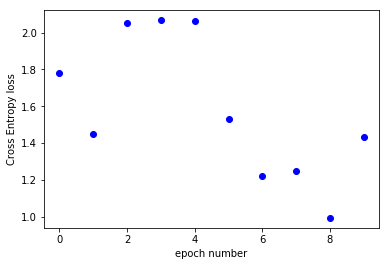

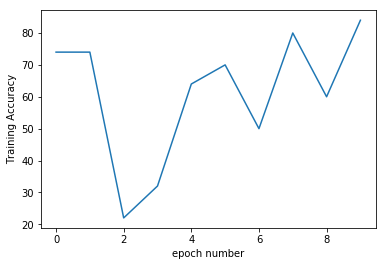

([1.7795386438302867,
  1.448189713532795,
  2.054518774362247,
  2.066806319461607,
  2.062834035944048,
  1.5289573674079342,
  1.2232770389118284,
  1.2504944401071711,
  0.9943109152539416,
  1.4358829109541602],
 [74.0, 74.0, 22.0, 32.0, 64.0, 70.0, 50.0, 80.0, 60.0, 84.0])

In [12]:
modelx.train(subsetx, lr=0.9,training_epochs=10, channels_of_image=1, image_dim=28, model_name = 'task2_modelx_epoch')

In [24]:
subsetx = td[:50]
subsetx.shape

(50, 785)

In [25]:
modely = Convolutional_Neural_Network()
#modely.saveModel('task2_modely_bestmodel.mdl')

[[9 0 0 0 0 0 0 0 0 0]
 [9 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [8 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]]
At epoch  0 loss is:  2.294626535039598 accuracy is:  18.0
[[9 0 0 0 0 0 0 0 0 0]
 [3 6 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]
 [8 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 0 0 0]]
At epoch  1 loss is:  2.2503913468885437 accuracy is:  30.0
[[2 5 0 0 0 0 2 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 4 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]]
At epoch  2 loss is:  2.204513326603287 accuracy is:  30.0
[[9 0 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0]
 [0 0 2 0 0 0 

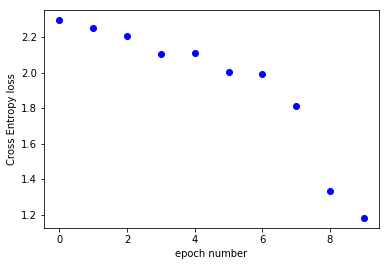

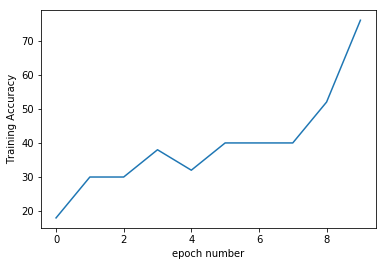

([2.294626535039598,
  2.2503913468885437,
  2.204513326603287,
  2.105729403012296,
  2.1115242487042694,
  2.0032034159919845,
  1.991986632570791,
  1.8140495835710286,
  1.3324811724771224,
  1.1813399105592142],
 [18.0, 30.0, 30.0, 38.0, 32.0, 40.0, 40.0, 40.0, 52.0, 76.0])

In [26]:
modely.train(subsetx, lr=0.9,training_epochs=10, channels_of_image=1, image_dim=28, model_name = 'task2_modely_epoch')

<h1>Loading Train and Test Data of CIFAR-10</h1>

In [3]:
#f = open(path+file, 'rb')

file = 'C:\\Users\\hp\\DL Assignments\\assignment3\\New folder\\cifar-10-python\\cifar-10-batches-py\\data_batch_1'
with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')

In [4]:
dict[b'data']

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [6]:
image = dict[b'data']
image = np.reshape(image, (10000, 3, 32, 32))
label = dict[b'labels']
images = mxnet.nd.array(image)
labels = mxnet.nd.array(label)

In [7]:
labels.shape

(10000,)

In [8]:
train_x = images.reshape((10000, 3*32*32))
train_x /= 255

train_y = labels
train_y = train_y.reshape(10000,1)

In [15]:
sub_x = train_x[:100]
sub_y = train_y[:100]

In [16]:
cifar_train = np.hstack((sub_x,sub_y))
np.random.shuffle(cifar_train)
cifar_subset = cifar_train[:100]
cifar_subset.shape

KeyboardInterrupt: 

In [17]:
from keras.datasets import cifar10

Using TensorFlow backend.


In [18]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [19]:
x_train.shape

(50000, 32, 32, 3)

In [20]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [21]:
print(x_train.shape)
x = x_train.reshape((x_train.shape[0], 32*32*3))
y = y_train

(50000, 32, 32, 3)


In [22]:
print(x.shape)
print(y.shape)

(50000, 3072)
(50000, 1)


In [23]:
y[0][0]

6

In [24]:
y_tr = np.zeros((50000,1))

In [25]:
y_tr[0]

array([0.])

In [46]:
cifar_train_ = np.hstack((x,y))
np.random.shuffle(cifar_train_)
cifar_subset_ = cifar_train_[:500]
cifar_subset_.shape

(500, 3073)

In [47]:
yy = cifar_subset_[:,-1]
yy

array([1., 1., 5., 2., 3., 5., 8., 4., 1., 3., 4., 0., 3., 8., 2., 1., 2.,
       1., 0., 9., 4., 5., 7., 0., 1., 5., 1., 7., 1., 4., 7., 4., 5., 1.,
       1., 3., 3., 2., 8., 5., 3., 7., 4., 4., 3., 0., 4., 6., 8., 3., 5.,
       9., 1., 6., 1., 3., 9., 9., 3., 5., 5., 4., 6., 4., 5., 0., 8., 1.,
       0., 5., 7., 6., 7., 4., 9., 4., 8., 0., 7., 6., 3., 7., 9., 2., 5.,
       5., 2., 4., 1., 8., 1., 2., 1., 1., 5., 3., 3., 0., 9., 0., 7., 7.,
       8., 5., 5., 6., 6., 6., 2., 5., 6., 5., 5., 4., 0., 6., 8., 3., 0.,
       9., 9., 5., 8., 2., 1., 7., 6., 0., 6., 6., 6., 2., 0., 3., 0., 0.,
       1., 7., 1., 2., 0., 3., 6., 3., 1., 0., 7., 3., 9., 3., 6., 1., 5.,
       0., 2., 0., 6., 3., 3., 7., 6., 6., 7., 5., 2., 1., 5., 5., 3., 2.,
       8., 1., 3., 2., 9., 2., 6., 3., 2., 0., 4., 0., 0., 8., 1., 3., 9.,
       7., 8., 9., 3., 7., 3., 7., 8., 5., 6., 4., 6., 2., 9., 0., 7., 3.,
       8., 8., 6., 8., 8., 8., 5., 7., 5., 9., 4., 5., 8., 2., 4., 4., 1.,
       3., 9., 5., 1., 0.

In [48]:
model_cifar = Convolutional_Neural_Network(channels_of_image=3)
#model_cifar.saveModel('task2_model_cifar_bestmodel.mdl')

In [ ]:
model_cifar.train(cifar_subset_, lr= 15,training_epochs=10, channels_of_image=3, image_dim=32, model_name = 'task2_model_cifar_epoch')

[[ 0 49  0  0  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0  0  0  0]
 [ 0 44  0  0  0  0  0  0  0  0]
 [ 0 58  0  0  0  0  0  0  0  0]
 [ 0 47  0  0  0  0  0  0  0  0]
 [ 0 52  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0]
 [ 0 46  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0]]
At epoch  0 loss is:  2.4607154985826805 accuracy is:  12.0
[[ 0 49  0  0  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0  0  0  0]
 [ 0 44  0  0  0  0  0  0  0  0]
 [ 0 58  0  0  0  0  0  0  0  0]
 [ 0 47  0  0  0  0  0  0  0  0]
 [ 0 52  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0]
 [ 0 46  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0]]
At epoch  1 loss is:  2.467369113519524 accuracy is:  12.0
